** Responses API - an agentic API for easy engagement with our frontier models through managed stateful conversations, tracing of responses to enable evaluation, and built-in tools for file search, web search, computer use, and more

** Agents SDK - a lightweight, customizable open source framework for building and orchestrating workflows across many different agents, enabling your assistant to route inputs to the appropriate agent and to scale to support many use cases

** Voice agents - an extension of the Agents SDK to support the use of voice pipelines, enabling your agents to go from being text-base to being able to interpret and produce audio in just a few lines of code

In [85]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [86]:
#print(os.getenv('EXAMPLE_BASE_URL'))

In [87]:
from agents import Agent, function_tool, WebSearchTool, FileSearchTool, set_default_openai_key
from agents.extensions.handoff_prompt import prompt_with_handoff_instructions

set_default_openai_key(os.getenv('OPENAI_API_KEY'))

## Defining Agents & Tools

Today we're going to be building an assitant for our fictitious consumer application, ACME shop, focussed on initially supporting use cases across three key use cases:

Answering real-time questions to inform purchasing decisions using web search
Providing information on the available options in our product portfolio
Providing account information to enable the user to understand their budget and spending
To achieve this we'll be using an agentic architecture. This allows us to split the functionality for each use case into a separate agent, in turn reducing the complexity/range of tasks that a single agent could be asked to complete and increasing accuracy. Our agent architecture is relatively simple focussing on the three use cases above, but the beauty of the Agents SDK is that it is incredibly easy to extend and add aditional agents to the workflow when you want to add new functionality:

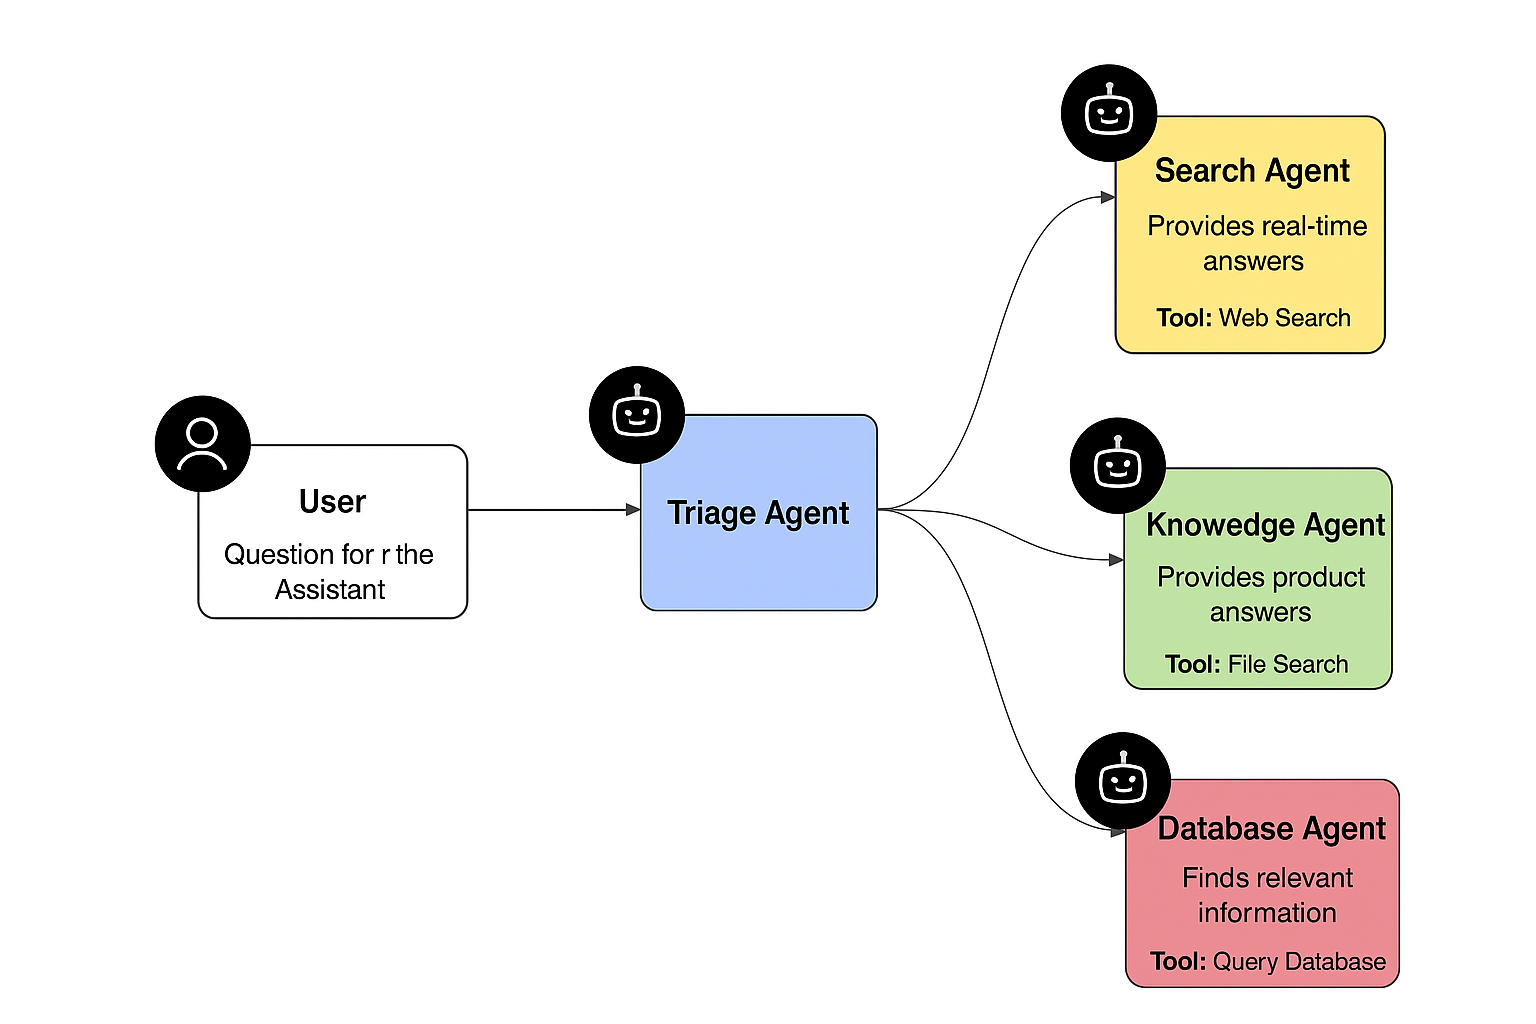

## Search Agent
Our first agent is a simple web search agent that uses the WebSearchTool provided by the Responses API to find real-time information on the user's query. We'll be keeping the instruction prompts simple for each of these examples, but we'll iterate later to show how to optimise the response format for your use case.

In [88]:
# --- Agent: Search Agent ---
search_agent = Agent(
    name="SearchAgent",
    instructions=(
        "You immediately provide an input to the WebSearchTool to find up-to-date information on the user's query."
    ),
    tools=[WebSearchTool()],
)

## Knowledge Agent

In [15]:
from openai import OpenAI
import os

client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

def upload_file(file_path: str, vector_store_id: str):
    file_name = os.path.basename(file_path)
    try:
        file_response = client.files.create(file=open(file_path, 'rb'), purpose="assistants")
        attach_response = client.vector_stores.files.create(
            vector_store_id=vector_store_id,
            file_id=file_response.id
        )
        return {"file": file_name, "status": "success"}
    except Exception as e:
        print(f"Error with {file_name}: {str(e)}")
        return {"file": file_name, "status": "failed", "error": str(e)}

def create_vector_store(store_name: str) -> dict:
    try:
        vector_store = client.vector_stores.create(name=store_name)
        details = {
            "id": vector_store.id,
            "name": vector_store.name,
            "created_at": vector_store.created_at,
            "file_count": vector_store.file_counts.completed
        }
        print("Vector store created:", details)
        return details
    except Exception as e:
        print(f"Error creating vector store: {e}")
        return {}
    
vector_store_id = create_vector_store("ACME Shop Product Knowledge Base")

Vector store created: {'id': 'vs_67f9134fe8d08191bb757c439fed2a4e', 'name': 'ACME Shop Product Knowledge Base', 'created_at': 1744376655, 'file_count': 0}


### Uploading the PDF File

In [29]:
upload_file("sample_pdf_files/deep-learning-r-tutorial.pdf", vector_store_id["id"])

{'file': 'deep-learning-r-tutorial.pdf', 'status': 'success'}

In [30]:
# --- Agent: Knowledge Agent ---
knowledge_agent = Agent(
    name="KnowledgeAgent",
    instructions=(
        "You answer user questions on our product portfolio with concise, helpful responses using the FileSearchTool."
    ),
    tools=[FileSearchTool(
            max_num_results=3,
            vector_store_ids=["VECTOR_STORE_ID"],
        ),],
)

## Database Agent Agent

In [93]:
import sqlite3

# Connect to SQLite database (or create one if it doesn't exist)
conn = sqlite3.connect('sample_users.db')
cursor = conn.cursor()

# Create table
cursor.execute('''
CREATE TABLE IF NOT EXISTS user_account_details (
    user_id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    account_balance TEXT NOT NULL,
    membership_status TEXT NOT NULL
)
''')

# Insert sample data
user_data = {
    "user_id": 72,
    "name": "Bugs Bunty",
    "account_balance": "£77.50",
    "membership_status": "Gold Executive"
}

cursor.execute('''
INSERT INTO user_account_details (user_id, name, account_balance, membership_status)
VALUES (:user_id, :name, :account_balance, :membership_status)
''', user_data)

# Commit and close
conn.commit()
conn.close()

print("Database and table created. Sample record inserted.")

Database and table created. Sample record inserted.


In [101]:
# --- Tool 1: Fetch account information (dummy) from SQL Database ---
@function_tool
def get_account_info(user_id: int) -> dict:
    """Fetch account info from the database for a given user_id."""
    conn = sqlite3.connect('sample_users.db')
    cursor = conn.cursor()

    cursor.execute('''
        SELECT user_id, name, account_balance, membership_status
        FROM user_account_details
        WHERE user_id = ?
    ''', (user_id,))
    
    row = cursor.fetchone()
    conn.close()

    if row:
        return {
            "user_id": row[0],
            "name": row[1],
            "account_balance": row[2],
            "membership_status": row[3]
        }
    else:
        return {"error": "User not found"}

# --- Agent: Account Agent ---
account_agent = Agent(
    name="AccountAgent",
    instructions=(
        "You provide account information based on a user ID using the get_account_info tool."
    ),
    tools=[get_account_info],
)

In [ ]:
## Custom Model
from agents import (
    Agent,
    Model,
    ModelProvider,
    OpenAIChatCompletionsModel,
    RunConfig,
    Runner,
    function_tool,
    set_tracing_disabled,
)
from openai import AsyncOpenAI

# if not BASE_URL or not API_KEY or not MODEL_NAME:
#     raise ValueError(
#         "Please set EXAMPLE_BASE_URL, EXAMPLE_API_KEY, EXAMPLE_MODEL_NAME via env var or code."
#     )


"""This example uses a custom provider for some calls to Runner.run(), and direct calls to OpenAI for
others. Steps:
1. Create a custom OpenAI client.
2. Create a ModelProvider that uses the custom client.
3. Use the ModelProvider in calls to Runner.run(), only when we want to use the custom LLM provider.

Note that in this example, we disable tracing under the assumption that you don't have an API key
from platform.openai.com. If you do have one, you can either set the `OPENAI_API_KEY` env var
or call set_tracing_export_api_key() to set a tracing specific key.
"""
client =AsyncOpenAI(
        base_url="https://generativelanguage.googleapis.com/v1beta",
        api_key="gsk_XXXXXXXXXXXXXXXXXXXXXXXXXX",
    )

set_tracing_disabled(disabled=True)

class CustomModelProvider(ModelProvider):
    def get_model(self, model_name: str | None) -> Model:
        return OpenAIChatCompletionsModel(model='gemini-2.0-flash', openai_client=client)


CUSTOM_MODEL_PROVIDER = CustomModelProvider()

In [103]:
# --- Agent: Triage Agent ---
triage_agent = Agent(
    name="Assistant",
    instructions=prompt_with_handoff_instructions("""
You are the virtual assistant for Acme Shop. Welcome the user and ask how you can help.
Based on the user's intent, route to:
- AccountAgent for account-related queries
- KnowledgeAgent for product FAQs
- SearchAgent for anything requiring real-time web search
"""),
    handoffs=[account_agent, knowledge_agent, search_agent],
)

In [105]:
## Run the workflow
# %%
from agents import Runner, trace

async def test_queries():
    examples = [
        #"What membership tier am I on and what’s my remaining account balance? My user ID is 72", # Account Agent test
         "What is Deep Learning?", # Knowledge Agent test
        # "Whats the current weather today?", # Search Agent test

    ]
    with trace("ACME App Assistant"):
        for query in examples:
            result = await Runner.run(triage_agent, query, run_config=RunConfig(model_provider=CUSTOM_MODEL_PROVIDER),)
            print(f"User: {query}")
            print(result.final_output)
            print("---")
# Run the tests

await test_queries()


UserError: Hosted tools are not supported with the ChatCompletions API. Got tool type: <class 'agents.tool.FileSearchTool'>, tool: FileSearchTool(vector_store_ids=['VECTOR_STORE_ID'], max_num_results=3, include_search_results=False, ranking_options=None, filters=None)

In [ ]:
# import PyPDF2

# # Path to your PDF file
# pdf_path = 'sample_pdf_files/deep-learning-r-tutorial.pdf'

# # Open the PDF file in read-binary mode
# with open(pdf_path, 'rb') as file:
#     reader = PyPDF2.PdfReader(file)
    
#     # Loop through all the pages and extract text
#     for i, page in enumerate(reader.pages):
#         text = page.extract_text()
#         print(f"\n--- Page {i+1} ---\n")
#         print(text)



--- Page 1 ---

Deep Learning in R: A Compr ehensive Guide
Table of Contents
1. Introduction to Deep Learning
2. Setting Up Y our R Environment
3. Neural Network Architectures
Multilayer Perceptrons (MLP)
Convolutional Neural Networks (CNN)
Recurrent Neural Networks (RNN)
4. Deep Learning Frameworks in R
Keras and T ensorFlow
MXNet
RSNNS for T raditional Neural Networks
5. Model Optimization and Regularization
6. Model Evaluation and Interpretation
7. Transfer Learning
8. Advanced T opics and Best Practices
9. Conclusion and Further Resources
1. Intr oduction to Deep Learning
Deep Learning is a subset of machine learning that uses artificial neural networks with multiple layers to learn representations of data. These deep
neural networks have revolutionized many fields, including computer vision, natural language processing, and speech recognition.
Key concepts in deep learning include:
Neurons and layers
Activation functions
Backpropagation
Gradient descent
Loss functions
In this tut